In [2]:
import torch
import networkx as nx
import pymimir as mi

In [4]:
import os
os.getcwd()

'/work/rleap1/jakob.krude/projects/remote/rgnet/examples'

In [5]:
from pymimir import Problem
from rgnet.utils import import_all_from

In [6]:
domain, problems = import_all_from("../test/pddl_instances/blocks")

In [7]:
problem: Problem = problems[0]
initial_state = problem.create_state(problem.initial)
initial_state.get_atoms()

[<Atom 'clear(a)'>,
 <Atom 'clear(c)'>,
 <Atom 'ontable(g)'>,
 <Atom 'ontable(f)'>,
 <Atom 'on(a, g)'>,
 <Atom 'on(c, d)'>,
 <Atom 'on(d, b)'>,
 <Atom 'on(b, e)'>,
 <Atom 'on(e, f)'>,
 <Atom 'handempty()'>]

In [8]:
problem.goal

[<Literal 'on(a, e)'>,
 <Literal 'on(e, b)'>,
 <Literal 'on(b, f)'>,
 <Literal 'on(f, g)'>,
 <Literal 'on(g, c)'>,
 <Literal 'on(c, d)'>]

In [9]:
a: mi.Atom = problem.goal[0].atom
a.terms

[<Object 'a'>, <Object 'e'>]

In [10]:
import itertools

# Build hetero graph from state
# One node for each object
# One node for each atom
# Edge label = position in atom
state = problem.create_state(problem.initial)
graph = nx.Graph()

for obj in problem.objects:
    graph.add_node(obj.name, type="obj")

state_atoms = zip(
    filter(lambda a: a.predicate.name != "=", state.get_atoms()),
    itertools.repeat(""),
    itertools.repeat(""),
)
goal_atoms = (
    (literal.atom, "~" if literal.negated else "", "_g")
    for literal in problem.goal
)

for atom, prefix, suffix in itertools.chain(state_atoms, goal_atoms):

    if atom.predicate.arity == 0:
        continue

    predicate: mi.Predicate = atom.predicate
    pred_name: str = predicate.name
    node_type = f"{prefix}{pred_name}{suffix}"
    graph.graph[node_type] = predicate.arity

    obj_names = ",".join(obj.name for obj in atom.terms)

    atom_node = f"{prefix}{pred_name}({obj_names}){suffix}"
    graph.add_node(
        atom_node,
        type=node_type,
    )

    for pos, obj in enumerate(atom.terms):
        # Connect predicate node to object node
        graph.add_edge(obj.name, atom_node, position=str(pos))



In [11]:
from collections import defaultdict

nodes_by_type = defaultdict(list)
for key, value in nx.get_node_attributes(graph, "type").items():
    nodes_by_type[value].append(key)
nodes_by_type

defaultdict(list,
            {'obj': ['e', 'b', 'd', 'f', 'g', 'c', 'a'],
             'clear': ['clear(a)', 'clear(c)'],
             'ontable': ['ontable(g)', 'ontable(f)'],
             'on': ['on(a,g)', 'on(c,d)', 'on(d,b)', 'on(b,e)', 'on(e,f)'],
             'on_g': ['on(a,e)_g',
              'on(e,b)_g',
              'on(b,f)_g',
              'on(f,g)_g',
              'on(g,c)_g',
              'on(c,d)_g']})

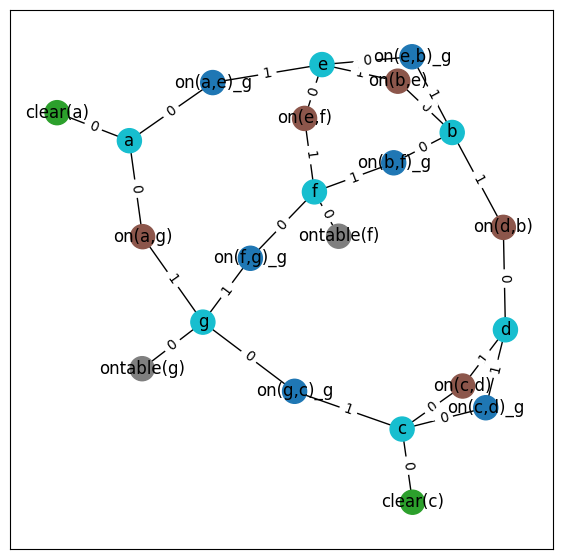

In [12]:
from matplotlib import pyplot as plt

type_to_color = {ntype: i for i, ntype in
                 enumerate(set(nx.get_node_attributes(graph, "type").values()))}
pos = nx.spring_layout(graph)
plt.figure(figsize=(7, 7))

nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=True,
    labels={n: str(n) for n in graph.nodes},
    nodelist=[n for n in graph.nodes],
    node_color=[type_to_color[attr["type"]] for _, attr in graph.nodes.data()],
    cmap="tab10",
)
nx.draw_networkx_edge_labels(graph, pos=pos,
                             edge_labels={(src, dst): attr["position"] for
                                          src, dst, attr in graph.edges.data()})
plt.show()

In [13]:
node_type = "on_g"
hidden_size = 4
arity = graph.graph[node_type]
# node features arity x hidden_size
node_features = torch.stack(
    [torch.zeros(hidden_size * arity) for _, attr in graph.nodes.data() if
     attr["type"] == node_type])
node_features

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
torch.zeros(len([1 for _, attr in graph.nodes.data() if attr["type"] == node_type]),
            hidden_size)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [15]:
from torch_geometric.data import HeteroData

In [16]:
obj_label = sorted([node for node, attr in graph.nodes.data() if attr["type"] == "obj"])
obj_label = {o: i for i, o in enumerate(obj_label)}
obj_label

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6}

In [17]:
torch.stack(
    [torch.full(fill_value=obj_label[node], size=(2,)) for node, attr in
     graph.nodes.data() if attr["type"] == "obj"])

tensor([[4, 4],
        [1, 1],
        [3, 3],
        [5, 5],
        [6, 6],
        [2, 2],
        [0, 0]])

In [18]:
# group nodes by type
by_type = {ntype: [node for node, attr in graph.nodes.data() if attr["type"] == ntype]
           for
           ntype in set(nx.get_node_attributes(graph, "type").values())}

nidx_by_type = {ntype: {node: i for i, node in enumerate(by_type[ntype])} for ntype in
                by_type.keys()}
nidx_by_type

{'on_g': {'on(a,e)_g': 0,
  'on(e,b)_g': 1,
  'on(b,f)_g': 2,
  'on(f,g)_g': 3,
  'on(g,c)_g': 4,
  'on(c,d)_g': 5},
 'clear': {'clear(a)': 0, 'clear(c)': 1},
 'on': {'on(a,g)': 0, 'on(c,d)': 1, 'on(d,b)': 2, 'on(b,e)': 3, 'on(e,f)': 4},
 'ontable': {'ontable(g)': 0, 'ontable(f)': 1},
 'obj': {'e': 0, 'b': 1, 'd': 2, 'f': 3, 'g': 4, 'c': 5, 'a': 6}}

In [19]:
# Build pyg HeteroData from graph
data = HeteroData()
hidden_size = 1
for node_type in set(nx.get_node_attributes(graph, "type").values()):
    if node_type == "obj":
        data[node_type].x = torch.stack(
            [torch.full(fill_value=obj_label[node], size=(hidden_size,),
                        dtype=torch.float32) for node, attr
             in graph.nodes.data() if attr["type"] == node_type])
    else:
        arity = graph.graph[node_type]
        data[node_type].x = torch.stack(
            [torch.zeros(arity * hidden_size, dtype=torch.float32) for _, attr in
             graph.nodes.data() if
             attr["type"] == node_type])

# Group edges by src, position, dst
edge_dict = {}
for src, dst, attr in graph.edges.data():
    src_type = graph.nodes[src]["type"]
    dst_type = graph.nodes[dst]["type"]
    if (src_type, attr["position"], dst_type) not in edge_dict:
        edge_dict[(src_type, attr["position"], dst_type)] = []
        edge_dict[(dst_type, attr["position"], src_type)] = []

    edge_dict[(src_type, attr["position"], dst_type)].append(
        torch.tensor([nidx_by_type[src_type][src], nidx_by_type[dst_type][dst]]))
    edge_dict[(dst_type, attr["position"], src_type)].append(
        torch.tensor([nidx_by_type[dst_type][dst], nidx_by_type[src_type][src]]))
# stack grouped tensors and add to data
for key, value in edge_dict.items():
    data[key[0], key[1], key[2]].edge_index = torch.stack(value, dim=1)

edge_types = edge_dict.keys()

In [20]:
torch.stack([torch.tensor([1, 2]), torch.tensor([3, 4]), torch.tensor([5, 6])], dim=1)

tensor([[1, 3, 5],
        [2, 4, 6]])

In [21]:
data.validate()

True

In [22]:
data.x_dict

{'on_g': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 'clear': tensor([[0.],
         [0.]]),
 'on': tensor([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]),
 'ontable': tensor([[0.],
         [0.]]),
 'obj': tensor([[4.],
         [1.],
         [3.],
         [5.],
         [6.],
         [2.],
         [0.]])}

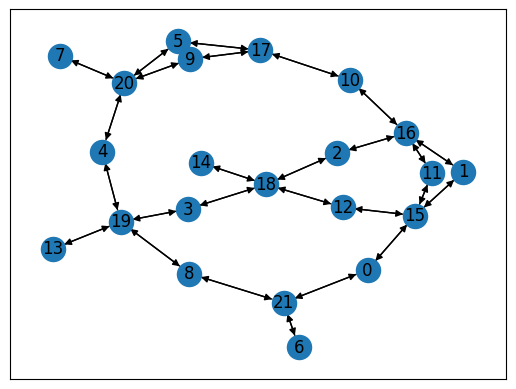

In [23]:
from torch_geometric.utils import to_networkx

hgraph: nx.Graph = to_networkx(data, to_multi=True)
pos = nx.spring_layout(hgraph)
nx.draw_networkx(hgraph)